# Data Cleaning

In [2]:
import pandas as pd

In [4]:
DGS1 = pd.read_excel("DATA/DGS1.xls", skiprows=10)
DGS2 = pd.read_excel("DATA/DGS2.xls", skiprows=10)
DGS3MO   = pd.read_excel("DATA/DGS3MO.xls", skiprows=10)
DGS6MO  = pd.read_excel("DATA/DGS6MO.xls", skiprows=10)
DGS10= pd.read_excel("DATA/DGS10.xls", skiprows=10)
DGS3 = pd.read_excel("DATA/DGS3.xls", skiprows=10)
DGS5= pd.read_excel("DATA/DGS5.xls", skiprows=10)
DGS7= pd.read_excel("DATA/DGS7.xls", skiprows=10)

#Drop the 0 columns
DGS1 = DGS1[(DGS1 != 0.00).all(axis=1)]
DGS2 = DGS2[(DGS2 != 0.00).all(axis=1)]
DGS3MO = DGS3MO[(DGS3MO != 0.00).all(axis=1)]
DGS6MO = DGS6MO[(DGS6MO != 0.00).all(axis=1)]
DGS10 = DGS10[(DGS10 != 0.00).all(axis=1)]
DGS3 = DGS3[(DGS3 != 0.00).all(axis=1)]
DGS5 = DGS5[(DGS5 != 0.00).all(axis=1)]
DGS7 = DGS7[(DGS7 != 0.00).all(axis=1)]

In [6]:
index_comparison = {
    'DGS2': set(DGS1.index) == set(DGS2.index),
    'DGS3MO': set(DGS1.index) == set(DGS3MO.index),
    'DGS6MO': set(DGS1.index) == set(DGS6MO.index),
    'DGS10': set(DGS1.index) == set(DGS10.index),
    'DGS3': set(DGS1.index) == set(DGS3.index),
    'DGS5': set(DGS1.index) == set(DGS5.index),
    'DGS7': set(DGS1.index) == set(DGS7.index),
}

for df_name, comparison_result in index_comparison.items():
    print(f"{df_name} has the same indices as DGS1: {comparison_result}")


DGS2 has the same indices as DGS1: True
DGS3MO has the same indices as DGS1: False
DGS6MO has the same indices as DGS1: True
DGS10 has the same indices as DGS1: True
DGS3 has the same indices as DGS1: True
DGS5 has the same indices as DGS1: True
DGS7 has the same indices as DGS1: True


In [42]:
difference1 = DGS1.index.difference(DGS3MO.index)

In [38]:
difference2 = DGS3MO.index.difference(DGS1.index)

In [7]:
# Assuming DGS1, DGS2, DGS3MO, DGS6MO, DGS10, DGS3, DGS5, DGS7 are already defined in your environment

# List of DataFrame variables to merge with DGS3MO
dataframes = [DGS1, DGS2, DGS6MO, DGS10, DGS3, DGS5, DGS7]

# Initialize a list to hold the merged DataFrames
merged_dataframes = []

# Iterate over the DataFrame list and merge each with DGS3MO based on indices
for df in dataframes:
    merged_df = pd.merge(DGS3MO, df, left_index=True, right_index=True, how='left')
    merged_dataframes.append(merged_df)

# Assuming you want to see the result of merging DGS3MO with DGS1 as an example
# This will print the merged DataFrame of DGS3MO with the first DataFrame in the list, which is DGS1
print(merged_dataframes[0])


     observation_date_x  DGS3MO observation_date_y  DGS1
0            2014-01-02    0.07         2014-01-02  0.13
1            2014-01-03    0.07         2014-01-03  0.13
2            2014-01-06    0.05         2014-01-06  0.12
3            2014-01-07    0.04         2014-01-07  0.13
4            2014-01-08    0.05         2014-01-08  0.13
...                 ...     ...                ...   ...
2638         2024-02-13    5.45         2024-02-13  4.99
2639         2024-02-14    5.43         2024-02-14  4.94
2640         2024-02-15    5.43         2024-02-15  4.93
2641         2024-02-16    5.44         2024-02-16  4.98
2643         2024-02-20    5.44         2024-02-20  4.97

[2522 rows x 4 columns]


In [8]:
from functools import reduce

# Assume df1, df2, df3, ... are DataFrame objects you want to merge
dataframes = [DGS3MO, DGS1, DGS2, DGS6MO, DGS10, DGS3, DGS5, DGS7]

# Using reduce to merge multiple DataFrames on a common key
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date'), dataframes)

In [118]:
time_period = merged_df.iloc[:,0].values

# Task B

Formulating Curve Fitting Problem

In [13]:
import scipy

In [14]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

# Assuming `merged_df` is your DataFrame

# Define the model function; in this case, a linear function
def linear_model(x, m, b):
    return m * x + b

# Initialize a dictionary to hold the fit parameters for each column
fit_parameters = {}

# Iterate over each column, excluding 'observation_date'
for column in merged_df.columns[1:]:  # Start from 1 to exclude 'observation_date'
    # Get the column values
    y_data = merged_df[column].values
    x_data = np.arange(len(y_data))  # Assuming x is the index
    
    # Apply curve fit
    params, _ = curve_fit(linear_model, x_data, y_data)
    
    # Store the parameters (slope and intercept)
    fit_parameters[column] = params

# Display the fit parameters for each column
fit_parameters
#the Two columns are slope and intercept

{'DGS3MO': array([ 0.00150543, -0.51707264]),
 'DGS1': array([ 0.00143662, -0.26240292]),
 'DGS2': array([0.00118778, 0.15327306]),
 'DGS6MO': array([ 0.00151382, -0.42727346]),
 'DGS10': array([3.28433254e-04, 1.92510187e+00]),
 'DGS3': array([0.00097105, 0.54129021]),
 'DGS5': array([6.50260387e-04, 1.16716676e+00]),
 'DGS7': array([4.73550687e-04, 1.59770871e+00])}

In [15]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

# Initialize a dictionary to hold the results
results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.87913573 -1.16230179 -3.74444308  1.27768612]
  MAE: 0.5707403738897879
  MSE: 0.569329222991669
  R2: 0.5126381813754123

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.89697779 -1.19581638 -3.72807745  1.27439072]
  MAE: 0.5677719237721739
  MSE: 0.5616923751678782
  R2: 0.5195713759247287

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-1.42191765e+03  1.42218988e+03 -1.30967475e+04 -1.51204297e-05]
  MAE: 0.5122858010288165
  MSE: 0.6398861255181036
  R2: 0.44457267433555037

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-7.13105071e+02  7.13377130e+02 -2.64681650e+04 -8.05303478e-06]
  MAE: 0.5078106223174963
  MSE: 0.6273553520666648
  R2: 0.4479867006126814

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.9363088  -1.3001542  -3.67961583  1.2377161 ]
  MAE: 0.5636829910948935
  MSE: 0.5507702770972008
  R2: 0.5351242366097174

5:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.91314194 -1.32462569 -3.55976361  1.221682

In [148]:
import seaborn as sns
lambdas = [value['Parameters'][3] for value in results.values()]
beta_0 = [value['Parameters'][0] for value in results.values()]
beta_1 = [value['Parameters'][1] for value in results.values()]
beta_2 = [value['Parameters'][2] for value in results.values()]
#sns.distplot(lambdas, bins=1000)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [17]:
from scipy.stats import mode
np.median(lambdas), mode(lambdas)[0],np.nanmean([_ if _>0 else np.nan for _ in lambdas])

/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_3961/3779931104.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  np.median(lambdas), mode(lambdas)[0],np.nanmean([_ if _>0 else np.nan for _ in lambdas])


(0.478295155267787, array([1.00213091]), 1.397628138375958)

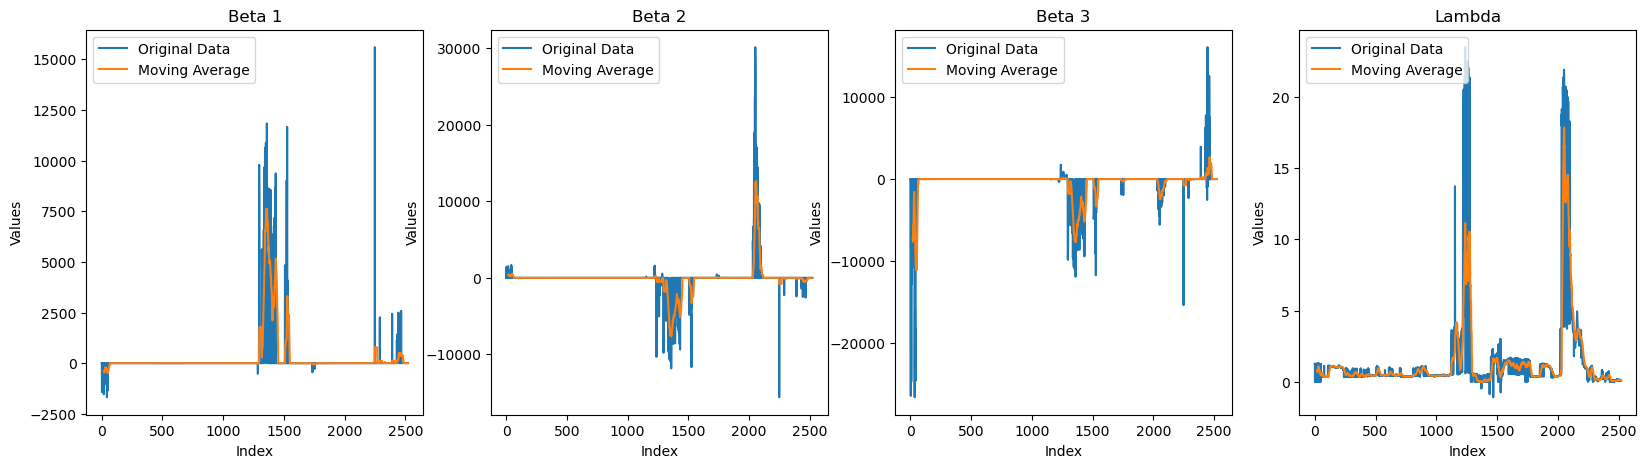

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    plt.subplot(1, 4, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(beta_1, 1, 'Beta 1')
plotting_param(beta_2, 2, 'Beta 2')
plotting_param(beta_3, 3, 'Beta 3')  # Assuming you have beta_3
plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()


Finding the optimal lambda with  time-series-crossvalidation

1. What is our loss function
2. How do we cross validate in time series
3. compare cross-validation against vanilla method


In [57]:
rounded_lambdas =  [round(num, 2) for num in lambdas]
len(set(rounded_lambdas))

415

{'mse': {...}, 'mae': {...}, 'r2': {...}}

In [58]:
%%time
# Initialize a dictionary to hold the results

op_lam = {}
lambda_range = set(rounded_lambdas)
min_mse = 10000000000000000000000
min_mae = 10000000000000000000000
min_r2 = 10000000000000000000000

for lambda_opt in lambda_range:
    print(lambda_opt)
    # Iterate over each column, excluding 'observation_date'
    for row in range(len(merged_df)):  # Excluding 'observation_date'
        y_data = merged_df.iloc[row].values[1:]
        x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])
    
        # print(x_data, y_data)
        
        # Apply curve fit
        #params, _ = curve_fit(NS_model, x_data, y_data,maxfev=10000)
        # print(params)
        
        # Predict using the fitted model
        y_pred = NS_model(x_data, results[row]['Parameters'][0],results[row]['Parameters'][1],results[row]['Parameters'][2],lambda_opt)
        
        # Calculate metrics
        mae = mean_absolute_error(y_data, y_pred)
        mse = mean_squared_error(y_data, y_pred)
        r2 = r2_score(y_data, y_pred)

        if mse < min_mse:
            op_lam["mse"]=lambda_opt
        if mae < min_mae:
            op_lam["mae"] = lambda_opt
        if r2 < min_r2:
            op_lam["r2"] = lambda_opt
            
        
print(op_lam)


-0.0
1.25
1.33
1.29
1.0
0.75
0.5
3.75
8.63
6.93
1.5
7.5
8.71
13.72
9.29
10.36
9.54
10.54
18.62
19.88
20.52
21.28
19.93
23.48
20.38
19.87
18.11
20.75
22.5
22.04
21.27
1.43
0.25
3.36
0.21
3.0
4.47
17.97
17.28
18.25
6.47
6.22
19.03
19.5
7.47
20.22
20.72
20.47
21.03
0.46
0.42
0.17
14.94
4.69
5.19
0.59
0.38
0.63
0.92
0.88
0.67
0.13
2.91
3.66
3.91
4.16
1.09
1.59
1.84
1.34
0.52
0.77
0.27
7.91
1.02
1.52
1.77
2.77
3.27
3.02
3.77
1.7
1.45
11.16
1.2
3.1
0.09
1.13
1.38
1.63
2.13
2.88
3.13
3.88
4.13
4.38
5.88
19.38
21.38
0.34
0.3
4.1
5.1
0.05
13.6
0.01
0.97
1.22
1.26
1.3
0.47
0.72
1.72
1.47
0.76
0.51
1.01
4.07
4.32
3.68
0.22
0.54
0.79
1.04
1.54
2.54
2.79
3.29
3.79
3.54
3.04
18.35
19.82
1.9
1.65
1.4
21.35
2.65
3.9
3.15
0.43
0.18
2.76
2.26
2.01
2.51
3.51
4.51
5.26
6.26
0.6
0.89
0.39
0.64
-0.86
0.35
0.93
0.85
0.68
0.14
9.7
0.1
2.2
4.2
17.7
4.95
18.95
19.98
0.56
0.81
19.7
20.48
20.7
1.31
1.06
1.56
21.45
21.7
21.48
2.56
2.06
2.31
3.56
0.99
0.74
0.49
3.81
3.31
1.74
1.49
3.06
0.24
0.31
0.06
1.67
1.17
1.42

In [61]:
op_lam_2 = op_lam

In [62]:
op_lam

{'mse': -1.08, 'mae': -1.08, 'r2': -1.08}

In [56]:
op_lam_1 = op_lam

{'mse': -1.1, 'mae': -1.1, 'r2': -1.1}

Part c: Optimal Parameter Fitting for beta_1, beta_2 and beta_3

In [80]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

def NS_model_lambda_fixed(s, beta_0,beta_1,beta_2):
    lmbda = -5
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

# Initialize a dictionary to hold the results
results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model_lambda_fixed, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model_lambda_fixed(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'lambda': -1.08,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  lambda: {metrics['lambda']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.39987381e-01 2.05970042e-15 4.11940019e-17]
  lambda: -1.08
  MAE: 0.5699877645405578
  MSE: 0.8092496271447045
  R2: 0.30725957130030557

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.53320428e-01 2.05269958e-15 4.10539851e-17]
  lambda: -1.08
  MAE: 0.5758213097083382
  MSE: 0.811865802400677
  R2: 0.3055921931207498

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.34987262e-01 2.02817907e-15 4.05635751e-17]
  lambda: -1.08
  MAE: 0.5724881129338295
  MSE: 0.8038429264895848
  R2: 0.30225659049429854

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.34987140e-01 2.00716546e-15 4.01433028e-17]
  lambda: -1.08
  MAE: 0.572488366049068
  MSE: 0.793142573726529
  R2: 0.30210964557004993

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.61652591e-01 2.11926585e-15 4.23853105e-17]
  lambda: -1.08
  MAE: 0.589154634293479
  MSE: 0.8183583481382584
  R2: 0.30926744300247755

5:
  Parameters (beta_0,beta_1,beta_2, lmbda): [7.49986001e-

In [81]:
import seaborn as sns
#lambdas = [value['Parameters'][3] for value in results.values()]
beta_1 = [value['Parameters'][0] for value in results.values()]
beta_2 = [value['Parameters'][1] for value in results.values()]
beta_3 = [value['Parameters'][2] for value in results.values()]
#sns.distplot(lambdas, bins=1000)

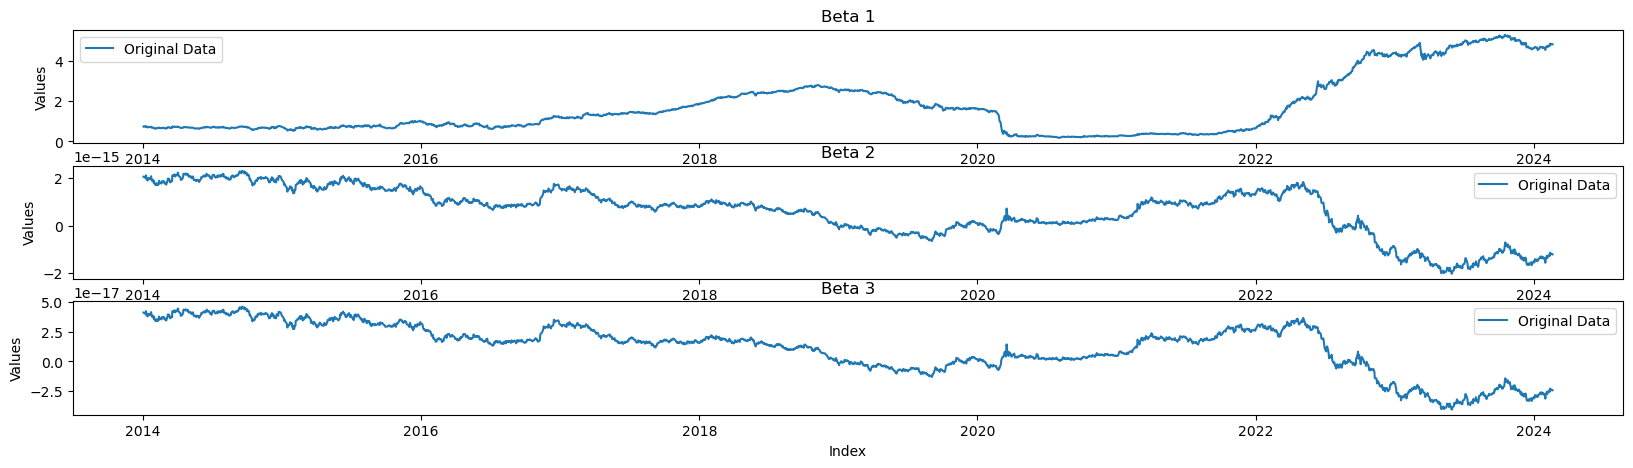

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the time range from the given start and end dates
#time_period


def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    #moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    lambdas_series = pd.Series(list_plot, index=time_period)
    plt.subplot(3, 1, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    #plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')
    

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(beta_1, 1, 'Beta 1')
plotting_param(beta_2, 2, 'Beta 2')
plotting_param(beta_3, 3, 'Beta 3')  # Assuming you have beta_3
#plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()

# Checking statistical topics and applying various time series model for each parameter

(ii) Investigate the statistical properties of the time series of these pa- rameters. Do they show any mean reversion properties, can they be modeled by any of the time series models (such as ARIMA)?

stationarity

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

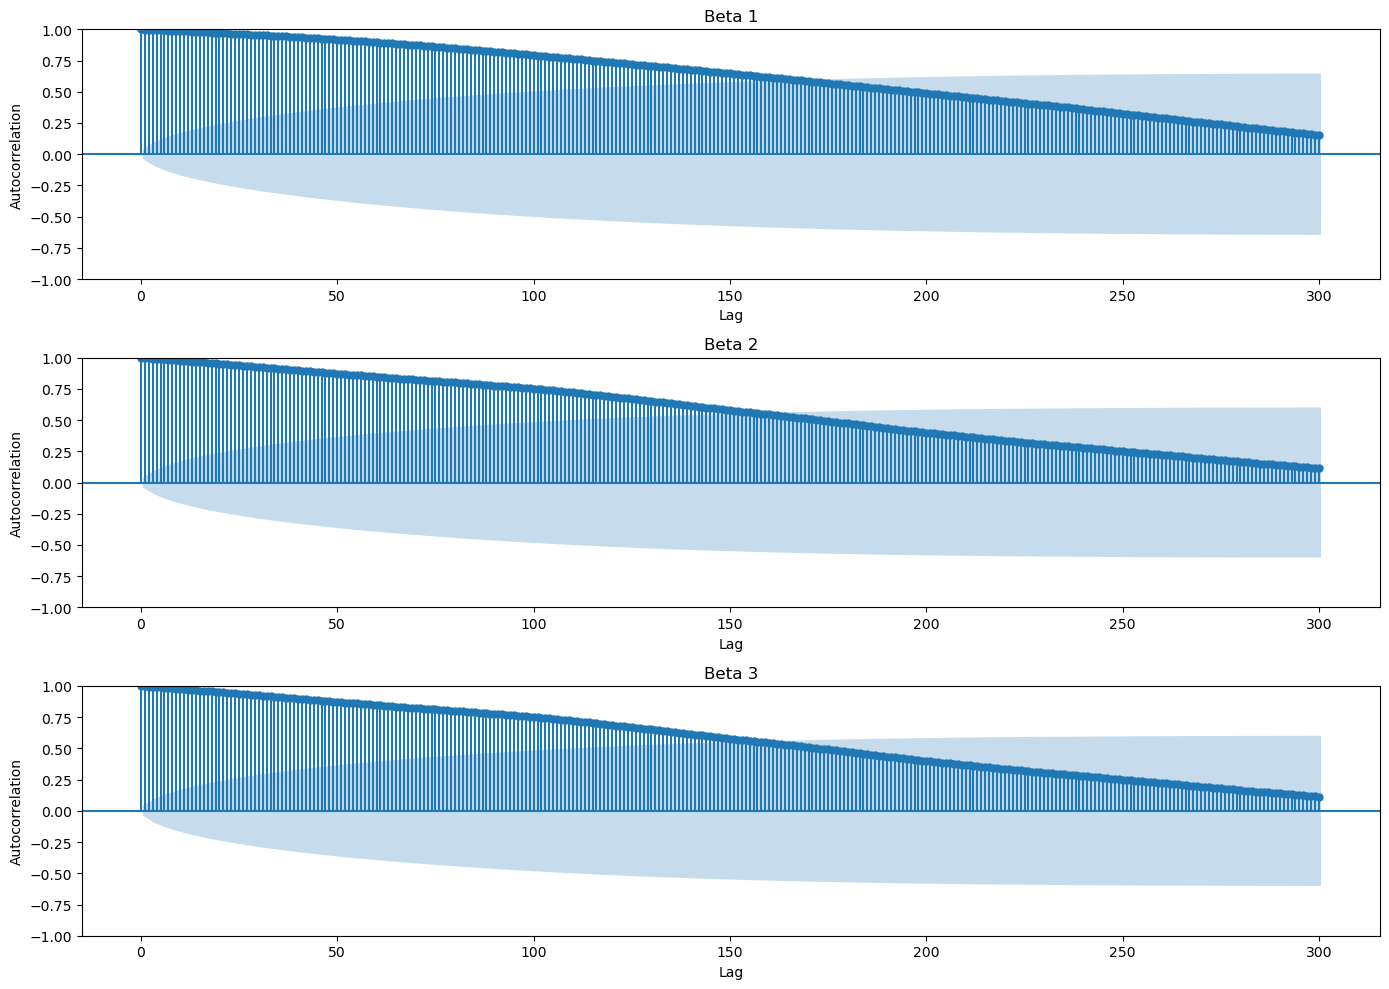

In [124]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(beta_1, 1, 'Beta 1')
plotting_auto_correlation(beta_2, 2, 'Beta 2')
plotting_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

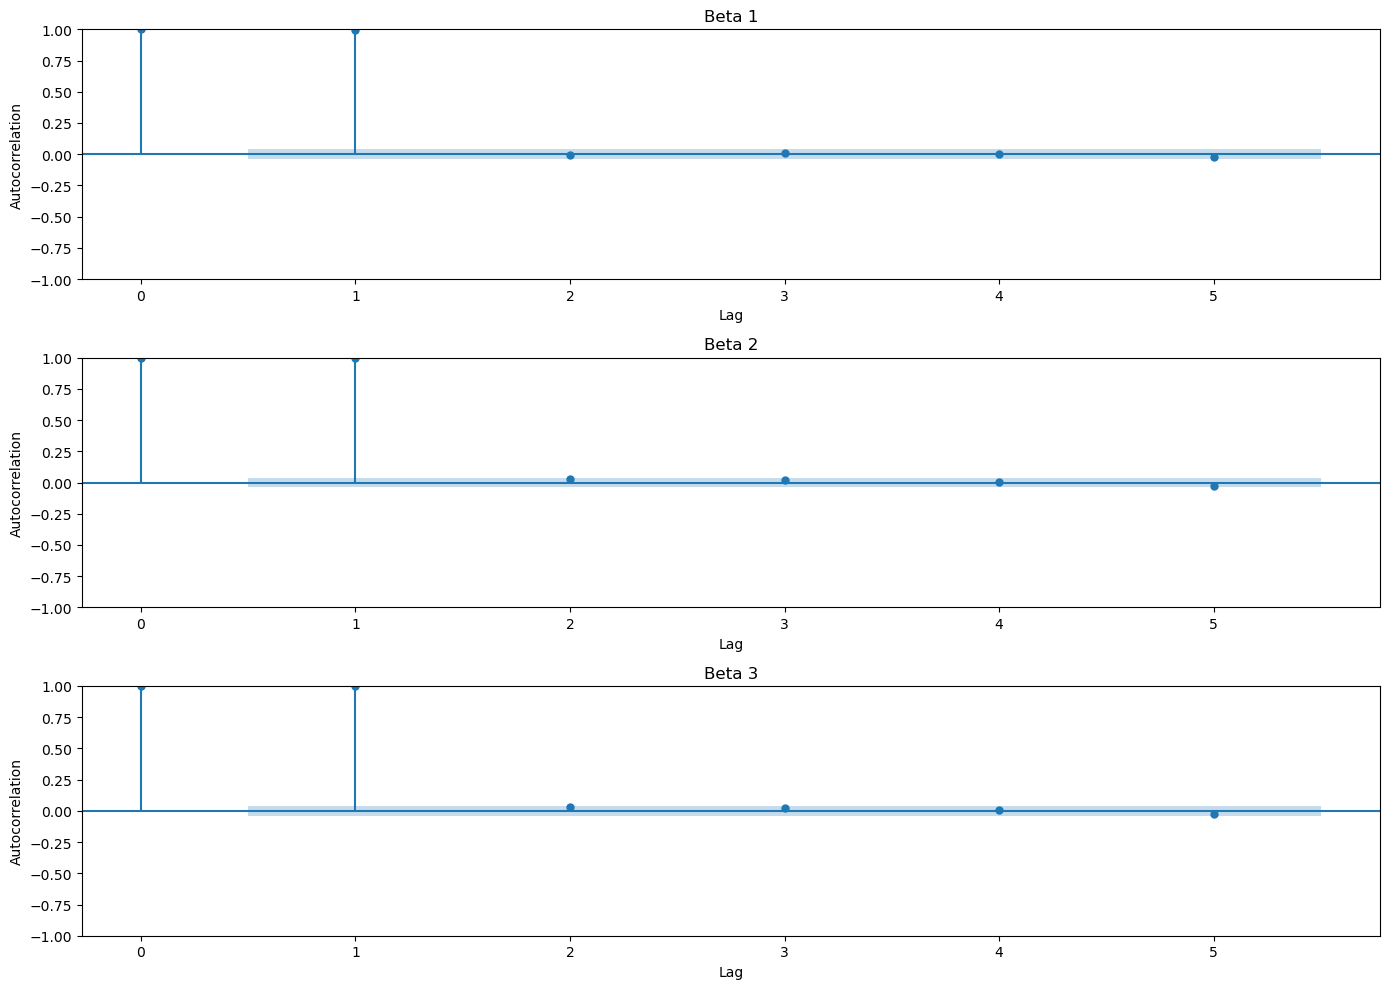

In [127]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=5, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(beta_1, 1, 'Beta 1')
plotting_partial_auto_correlation(beta_2, 2, 'Beta 2')
plotting_partial_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [138]:
from statsmodels.tsa.stattools import adfuller

def check_mean_reversion(series, name):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("The series " + name + "is likely mean-reverting.")
    else:
        print("The series " + name + " is not likely mean-reverting.")

# Assume 'time_series' is your pandas Series
check_mean_reversion(beta_1, "beta 1")
check_mean_reversion(beta_2, "beta 2")
check_mean_reversion(beta_3, "beta 3")

ADF Statistic: 0.308294
p-value: 0.977722
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 1 is not likely mean-reverting.
ADF Statistic: -1.001805
p-value: 0.752606
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 2 is not likely mean-reverting.
ADF Statistic: -1.162980
p-value: 0.689315
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 3 is not likely mean-reverting.


# Check if the series are the same.

In [141]:
mean_2 = np.mean(beta_2)
mean_3 = np.mean(beta_3)

In [142]:
tr_beta_2 = beta_2/mean_2
tr_beta_3 = beta_3/mean_3

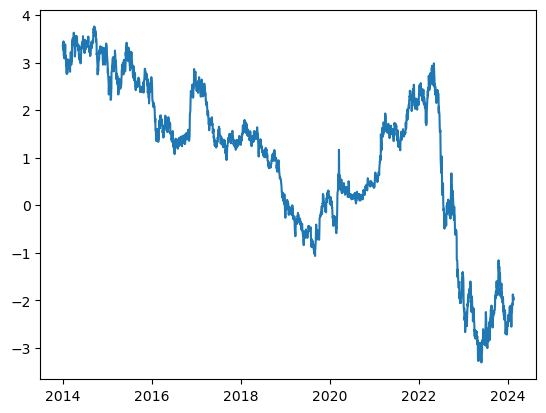

In [144]:
lambdas_series = pd.Series(tr_beta_2, index=time_period)
plt.plot(lambdas_series, label='Original Data')

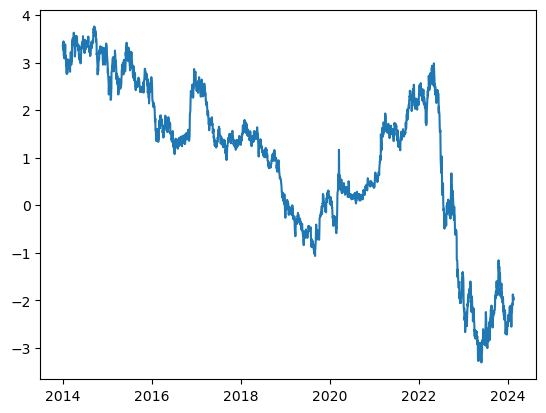

In [145]:
lambdas_series = pd.Series(tr_beta_3, index=time_period)
plt.plot(lambdas_series, label='Original Data')

In [147]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(tr_beta_2, tr_beta_3)
mse

5.530495801005996e-15

# stationarity

In [149]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Assuming 'time_series' is your pandas Series
def check_stationarity(ts,name):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(ts, autolag='AIC')  # AIC is used to select the best lag length
    
    result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        result['Critical Value (%s)' % key] = value
        
    print(result)
    
    # Interpretation
    if result['p-value'] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# Assume 'time_series' is your pandas Series
check_stationarity(beta_1, "beta 1")
check_stationarity(beta_2, "beta 2")
check_stationarity(beta_3, "beta 3")

Results of Augmented Dickey-Fuller Test:
Test Statistic                    0.308294
p-value                           0.977722
#Lags Used                       22.000000
Number of Observations Used    2499.000000
Critical Value (1%)              -3.432969
Critical Value (5%)              -2.862697
Critical Value (10%)             -2.567386
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.001805
p-value                           0.752606
#Lags Used                       25.000000
Number of Observations Used    2496.000000
Critical Value (1%)              -3.432973
Critical Value (5%)              -2.862699
Critical Value (10%)             -2.567387
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.162980
p-value                           0.689315
#Lags Used                        0.000000
Number of Observations Used    2521.000000

In [163]:
diff_beta_1 = pd.DataFrame(beta_1)
diff_beta_2 = pd.DataFrame(beta_2)
diff_beta_3 = pd.DataFrame(beta_3)

In [164]:
diff_beta_1.diff(1).dropna()
diff_beta_2.diff(1).dropna()
diff_beta_3.diff(1).dropna()

,0
1,-1.400168e-19
2,-4.904101e-19
3,-4.202722e-19
4,2.242008e-18
5,-3.502819e-19
...,...
2517,2.662467e-18
2518,-7.006364e-19
2519,-7.706698e-19
2520,9.808956e-19


In [165]:
# Assuming 'time_series' is your pandas Series
def check_stationarity(ts,name):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(ts, autolag='AIC')  # AIC is used to select the best lag length
    
    result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        result['Critical Value (%s)' % key] = value
        
    print(result)
    
    # Interpretation
    if result['p-value'] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# Assume 'time_series' is your pandas Series
check_stationarity(diff_beta_1, "beta 1")
check_stationarity(diff_beta_2, "beta 2")
check_stationarity(diff_beta_3, "beta 3")

Results of Augmented Dickey-Fuller Test:
Test Statistic                    0.308294
p-value                           0.977722
#Lags Used                       22.000000
Number of Observations Used    2499.000000
Critical Value (1%)              -3.432969
Critical Value (5%)              -2.862697
Critical Value (10%)             -2.567386
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.001805
p-value                           0.752606
#Lags Used                       25.000000
Number of Observations Used    2496.000000
Critical Value (1%)              -3.432973
Critical Value (5%)              -2.862699
Critical Value (10%)             -2.567387
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.162980
p-value                           0.689315
#Lags Used                        0.000000
Number of Observations Used    2521.000000

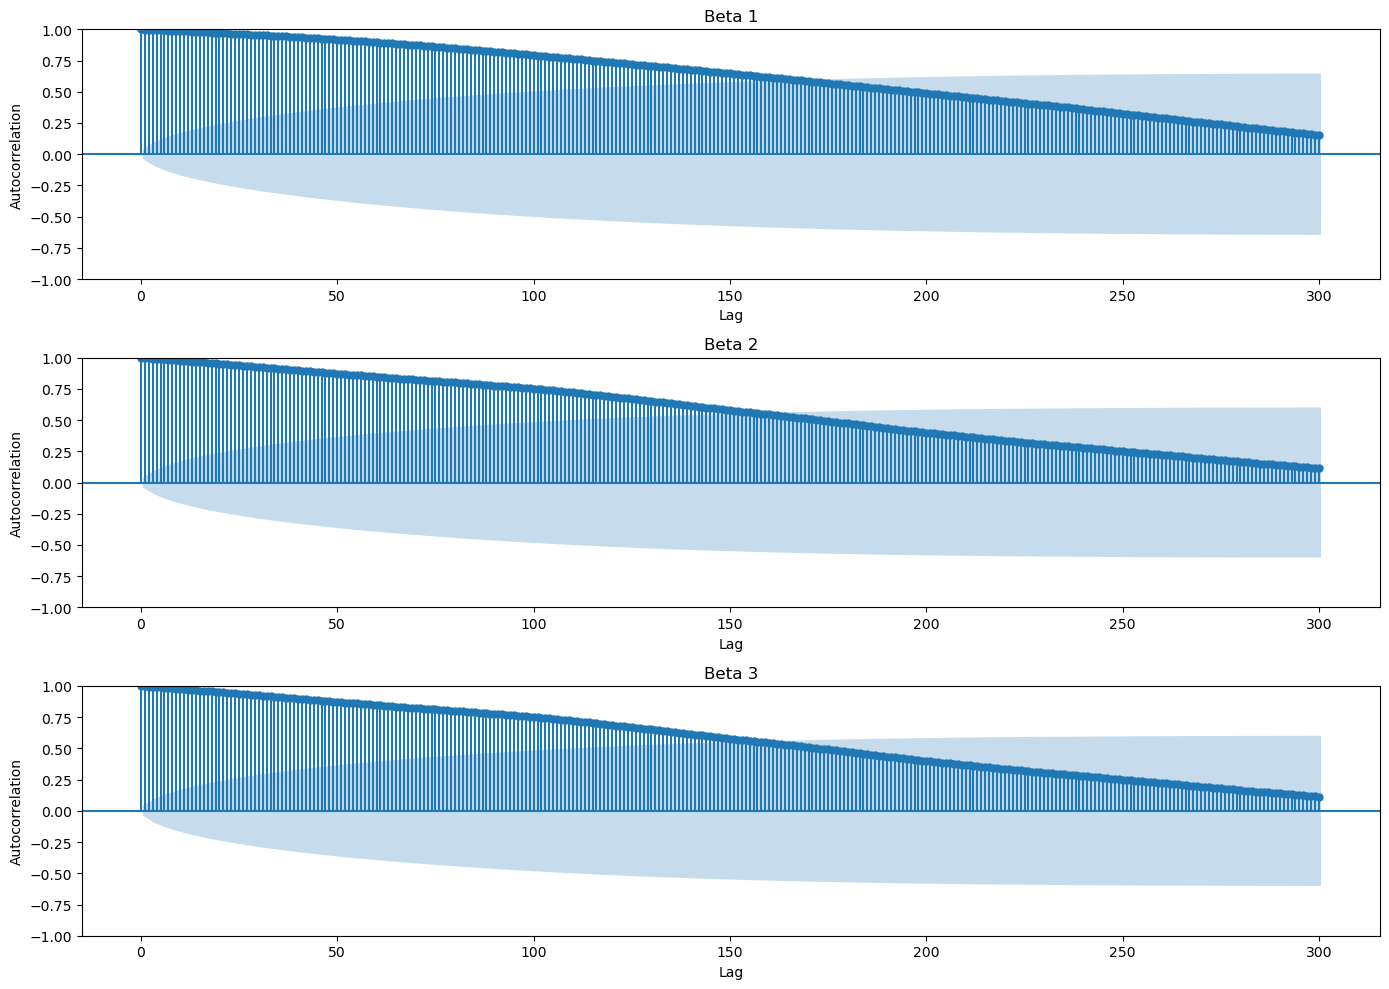

In [170]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(diff_beta_1, 1, 'Beta 1')
plotting_auto_correlation(diff_beta_2, 2, 'Beta 2')
plotting_auto_correlation(diff_beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Optimal Beta 1 Model

In [192]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(18,23):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_1, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

In [196]:
print(bic_res)
print(aic_res)
print(combined_res)

(2, 3, 22)
(2, 1, 19)
(2, 1, 19)


In [198]:
model = ARIMA(beta_1, order=(2, 1, 19))
model_fit = model.fit()

# Check the summary
print(model_fit.summary())

/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                 2522
Model:                ARIMA(2, 1, 19)   Log Likelihood                4915.819
Date:                Sun, 25 Feb 2024   AIC                          -9787.638
Time:                        22:39:00   BIC                          -9659.325
Sample:                             0   HQIC                         -9741.074
                               - 2522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3266      0.240      1.362      0.173      -0.143       0.797
ar.L2         -0.3608      0.196     -1.838      0.066      -0.746       0.024
ma.L1         -0.3212      0.239     -1.342      0.1

# Optimal Beta 2

In [201]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(1,15):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_2, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

In [205]:
combined_res

(2, 2, 1)

In [207]:

model = ARIMA(beta_2, order=(2, 2, 1))  # using d=1 as found in step 1
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                 2522
Model:                 ARIMA(2, 2, 1)   Log Likelihood               31651.589
Date:                Sun, 25 Feb 2024   AIC                         -63295.177
Time:                        22:47:38   BIC                         -63271.849
Sample:                             0   HQIC                        -63286.712
                               - 2522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0210    7.8e-05    269.131      0.000       0.021       0.021
ar.L2         -0.0105    7.4e-05   -141.989      0.000      -0.011      -0.010
ma.L1         -0.8052      0.000  -2284.337      0.0

/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Find the optimal Parameters for Beta 1 for GARCH, FAILING so far

In [223]:
from arch import arch_model


            
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for q in range(5,25):
    # Specifying a GARCH(1, 1) model
    garch_model = arch_model(beta_1, vol='Garch', p=2, q=q)

    # Fit the model
    garch_fit = garch_model.fit(disp='off')  # disp='off' turns off the convergence output
    if garch_fit.aic < best_aic:
        aic_res =   [2,q]
        best_aic = garch_fit.aic
            
    if garch_fit.bic < best_bic:
        bic_res =  [2,q]
        best_bix = garch_fit.bic
    
    if garch_fit.bic + garch_fit.aic < combined_bic:
        combined_res =   [2,q]
        combined_bic = garch_fit.bic + garch_fit.aic


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:765: Converge

In [227]:
print(aic_res)
print(bic_res)
print(combined_res)

[2, 9]
[2, 24]
[2, 9]


In [233]:
from arch import arch_model

# Specifying a GARCH(1, 1) model
garch_model = arch_model(beta_2, vol='Garch', p=2, q=9)

# Fit the model
garch_model.fit(update_freq=5, disp='off', show_warning=True, tol=1e-6)
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                84455.7
Distribution:                  Normal   AIC:                          -168885.
Method:            Maximum Likelihood   BIC:                          -168810.
                                        No. Observations:                 2522
Date:                Sun, Feb 25 2024   Df Residuals:                     2521
Time:                        22:57:02   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.1519e-16  6.067e-19   1014.055      0.000 [6.

/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.051e-30. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+15 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


## Garch Model not converging

(iii) Can the yield predictions based on the time series properties of the parameters be used for profitable trading?

In [234]:
# We need to implement a backtest here with the functions we calibrated and include train test split.
#Furthermore rename beta_1 and beta_2

(iv) Develop an ML based (using xgboost, or neural net based) frame- work of analysis of the parameters leading to a profitable strategy?

(v) Can the yield predictions based on the ML approach lead to prof- itable trading?